# Evaluating ADPE predictions
This notebook evaluates one model at the time to build AUC curves and other metrics to find an optimal threshold to filter predictions under some optimal penalization target.  
### A definition:  
Below we use the terms "snap" and "match". A snap is a prediction found within a set snapping distance to a known penguin. A match is a prediction that is determined to be the only, or the best snap to a known penguin.  
### The logic of finding a snap and a match:  
We want to match predictions to known penguins first in descending order of probability. So for each tile, we start sorting the predictions in descending order of probability. We loop while there are predictions to match to a known penguin.  
  * If there are snaps*:
    * Take the closest one, the prediction is a TP; remove the known penguin from table of knowns
  * No snaps:
    * The prediction is a FP
  * If there are no more known penguins to snap to:
    * All remaining predictions are FP 
  * No more predictions but still some known penguins
    * The remaining known penguins are FN
    
(*) A snap is made first by doing a Manhattan filter and finding all validation penguins on whose drawn box (drawn by the volunteers) the prediction falls. If the prediction falls within only one box, that's the snap. If the prediction falls within more than one box, we take the one whose center is closest to the prediction's center.

In [1]:
## Preliminaries
libs<-c("ggplot2","plyr")
lapply(libs, require, character.only = TRUE)

basedir<-"~/Workspace/ADPEvalidations/data/croz20191202_preds/"

Loading required package: ggplot2

Loading required package: plyr



[[1]]
[1] TRUE

[[2]]
[1] TRUE

In [2]:
## Function to snap a prediction to one or more known penguins
# pID is the ID of the penguin prediction we are tryng to snap
# prob is the probability of the prediction
# pcoords is the x.y vector of coordinates of that prediction
# validtable is the (ever shrinking) table of known, yet to be snapped penguins in the same tile as pID
# Return: the top snap as a match or no match as a data.frame:
#        penguinID, prob, validID, distance, match
findSnaps<-function(pID,prob,pcoords,validtiletable){
    # ...if there are records in validtiletable
    if(nrow(validtiletable)>0){
        # Find the snaps, sort by distance, take the closest if any found
        vttmf<-subset(validtiletable,(boxT>=pcoords[2]) & (boxB<=pcoords[2]) & (boxR>=pcoords[1]) & (boxL<=pcoords[1]))
        if(nrow(vttmf)>0){
            #take the closest penguin to the prediction
            vttmf$dist<-as.numeric(sapply(1:nrow(vttmf),function(rr,vttmf,pcoords){
                                vx<-vttmf[rr,"tilx"];vy<-vttmf[rr,"tily"]
                                distv<-sqrt(((pcoords[1]-vx)^2)+((pcoords[2]-vy)^2))
                                return(distv)
                        },vttmf=vttmf,pcoords=pcoords))
            ttmf<-vttmf[order(vttmf$dist),]
            sdf<-data.frame(penguinID=pID, prob=prob, validID=vttmf[1,"validID"], distance=vttmf[1,"dist"], match="TP")
        }else{
            #No detection within the box
            sdf<-data.frame(penguinID=pID, prob=prob, validID=NA, distance=NA, match="FP")
        }

    }else{ #no more valids to snap to
        sdf<-data.frame(penguinID=pID, prob=prob, validID=NA, distance=NA, match="FP")
    }

    return(sdf)
}

In [3]:
## Function to loop through all predictions in a tile and try to match them
# predsttable is the table with predictions
# validttable is the table of known penguin presences
# Return: a data.frame with match results
matchPredictions<-function(predsttable, validttable){

    snapsdf<-data.frame()
    
    nvr<-nrow(subset(validttable,label!="no_ADPE"))
    #If no predictions to the tile...(possibly all FN)
    if(nrow(predsttable)==0){

        #If there are validation records...
        if(nvr>0){
            # If there are penguins, these are FN
            fnrecs<-data.frame(penguinID=rep(NA,nvr), prob=rep(1,nvr), validID=validttable$validID, distance=rep(NA,nvr), match="FN")
            snapsdf<-fnrecs
        }else{
            # If there are no penguins, this is a no_ADPE tile, and a TN record
            tnprec<-data.frame(penguinID=NA, prob=1, validID=NA, distance=NA, match="TN")
            snapsdf<-tnprec
        }

    }else{
        # There are predictions, but what if no penguins found by observers?
        if(nvr==0){
            # No penguins in the tile, all predictions are FP
            fprecs<-data.frame(penguinID=predsttable$penguinID, prob=predsttable$probDet, validID=NA, distance=NA, match="FP")
            snapsdf<-fprecs
        }else{
            #we have both penguins and predictions, so...
            #sort preds by prob descending
            predsttable<-predsttable[order(predsttable$probDet, decreasing=T),]

            #loop through each to find snaps with findSnaps
            for(pID in predsttable$penguinID){
                ptt<-subset(predsttable,penguinID==pID)
                prob<-ptt$probDet
                pcx<-ptt$tilx;pcy<-ptt$tily

                #snap it
                snapt<-findSnaps(pID=pID,prob=prob,pcoords=c(pcx,pcy),validtiletable=validttable)

                #take result and add to tally
                snapsdf<-rbind(snapsdf,snapt)

                #update the validttable as needed
                snapID<-snapt$validID
                if(!is.na(snapID)){
                    validttable<-subset(validttable, validID != snapID)
                }

                #if no more valids in validttable, let findSnaps handle it - set all remaining preds to FP

            }

            #if there are still valids, all these are FN - need to set prob to 1 so when penalizing we always have them there
            unvr<-nrow(validttable)
            if(unvr>0){
                fnrecs<-data.frame(penguinID=rep(NA,unvr), prob=rep(1,unvr), validID=validttable$validID, distance=rep(NA,unvr), match="FN")
                #add to tally
                snapsdf<-rbind(snapsdf,fnrecs)
            }
        }
    }
    
    return(snapsdf)
}


In [4]:
## load the data - CAREFUL filtering the labels to match the model
# label "ADPE_a_stand" = model "adult_stand_s5_best"
# label "ADPE_a" =  model "adult_s2_best"
preddf<-read.csv(paste0(basedir,"croz_20191202_preds_adult_stand_s5_best.csv"))
valdf<-read.csv(paste0(basedir,"croz_20191202_validation_labels.csv"))
valdf<-subset(valdf,label %in% c("no_ADPE","ADPE_a_stand"))

In [5]:
## NEED to use pixels, no relative positions - in both predictions and validations
tiledims<-c(512,256)
valdf$tilx<-round(valdf$x*tiledims[1])
valdf$tily<-round(valdf$y*tiledims[2])
# Using a Manhattan filter before the Euclidian, with the box drawn by volunteers
# And the Euclidian only to choose the presence nearest to the prediction if there are many within the Manhattan filter
valdf$boxL<-round((valdf$x-valdf$width)*tiledims[1])
valdf$boxR<-round((valdf$x+valdf$width)*tiledims[1])
valdf$boxT<-round((valdf$y+valdf$height)*tiledims[2])
valdf$boxB<-round((valdf$y-valdf$height)*tiledims[2])
preddf$tilx<-round(preddf$relX*tiledims[1])
preddf$tily<-round(preddf$relY*tiledims[2])

In [6]:
## MATCHING!
tiles<-unique(valdf$tileName)
# Filtering out bad tiles
badValTiles<-c("croz_20191202_151_407", "croz_20191202_115_347", "croz_20191202_126_404", 
               "croz_20191202_131_396", "croz_20191202_283_506", "croz_20191202_56_292")
tiles<-tiles[which(!tiles %in% badValTiles)]

validationsdf<-ldply(tiles,function(tt,predstable, validtable){
            predsttable<-subset(predstable,grepl(tt,tilename))
            vttable<-subset(validtable,tileName==tt)

            #Add a unique ID to each validation record, so we can have referential integrity to each prediction
            validttable<-ldply(unique(vttable$tileName),function(tnam,vttable){
                        vtt<-subset(vttable,tileName==tnam)
                        vtt$validID<-paste0(tnam,"::",1:nrow(vtt))
                        return(vtt)
                    },vttable=vttable)

            rdf<-matchPredictions(predsttable=predsttable,validttable=validttable)
            if(nrow(rdf)>0){rdf$tilename<-tt}
            return(rdf)
        },predstable=preddf, validtable=valdf)

In [7]:
nrow(validationsdf)
sum(validationsdf$match=="TP")
sum(validationsdf$match=="FP")
sum(validationsdf$match=="FN")
sum(validationsdf$match=="TN")

[1] 6128

[1] 961

[1] 4651

[1] 301

[1] 215

In [8]:
hurdvals<-seq(0.01,0.99,by=0.01)
beta<-0.5
hurdlesdf<-ldply(hurdvals,function(mm,matches,beta){
                        #Here are the records above hurdle, to be counted as-is
                        mdf<-subset(matches,prob>=mm)
    
                        #These are the records below hurdle...
                        # TP becomes FN, FP goes to TN, and we must count these. All others don't change
                        fdf<-subset(matches,prob<mm) 
                        
                        trval<-sum(mdf$match=="TP")
                        fnval<-sum(mdf$match=="FN") + sum(fdf$match=="TP")
                        fpval<-sum(mdf$match=="FP")
                        tnval<-sum(mdf$match=="TN") + sum(fdf$match=="FP")
                        sens<-ifelse(trval+fnval==0,0,trval/(trval+fnval))
                        spec<-ifelse(tnval+fpval==0,0,tnval/(tnval+fpval))
                        prec<-ifelse(trval+fpval==0,0,trval/(trval+fpval))
                        f1val<-ifelse(sens+prec==0,0,(2*sens*prec)/(sens+prec))
                        miss<-ifelse(trval+fnval==0,0,fnval/(trval+fnval))
                        fpper<-ifelse(trval+fpval==0,0,fpval/(trval+fpval))
                        fbeta<-(1+(beta^2))*((prec*sens)/(((beta^2)*prec) + sens))
                        hurddf<-data.frame(Hurdle=mm,count=sum(trval,fnval,fpval),truePos=trval,falseNeg=fnval,falsePos=fpval,
                                            trueNeg=tnval,F1val=f1val,Sens=sens,Spec=spec,FPrate=1-spec,Prec=prec,
                                           Miss=miss,FPper=fpper,Fbeta=fbeta,beta=beta)

                        return(hurddf)
            },matches=validationsdf,beta=beta)


In [9]:
head(hurdlesdf)

,Hurdle,count,truePos,falseNeg,falsePos,trueNeg,F1val,Sens,Spec,FPrate,Prec,Miss,FPper,Fbeta,beta
,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01,5913,961,301,4651,215,0.2796043,0.7614897,0.04418413,0.9558159,0.1712402,0.2385103,0.8287598,0.2026571,0.5
2,0.02,4608,913,349,3346,1520,0.3307372,0.7234548,0.31237156,0.6876284,0.2143696,0.2765452,0.7856304,0.2494808,0.5
3,0.03,3945,872,390,2683,2183,0.3620511,0.6909667,0.44862310,0.5513769,0.2452883,0.3090333,0.7547117,0.2816174,0.5
4,0.04,3538,843,419,2276,2590,0.3848436,0.6679873,0.53226469,0.4677353,0.2702789,0.3320127,0.7297211,0.3068132,0.5
5,0.05,3285,816,446,2023,2843,0.3979517,0.6465927,0.58425812,0.4157419,0.2874251,0.3534073,0.7125749,0.3233476,0.5
6,0.06,3074,803,459,1812,3054,0.4142378,0.6362916,0.62762022,0.3723798,0.3070746,0.3637084,0.6929254,0.3425183,0.5


## Examining four penalizations
Below we explore the following penalizations:  
  * Hurdle at the point where we get most TP detections per FP detection (green color below)
  * Hurdle at the point where detections match the known number of penguins (purple color below)
  * Hurdle at the point where FP represent <10% of all detections
  * Hurdle at max(F0.5). The metric F_at_beta=0.5 is one way to penalize the model to have more TP to FP (orange color)
We review each in terms of total number of etections vs. true number of pengions counted, the inflation/deflation factor to use to correct the counts, the ratio of TP to FP

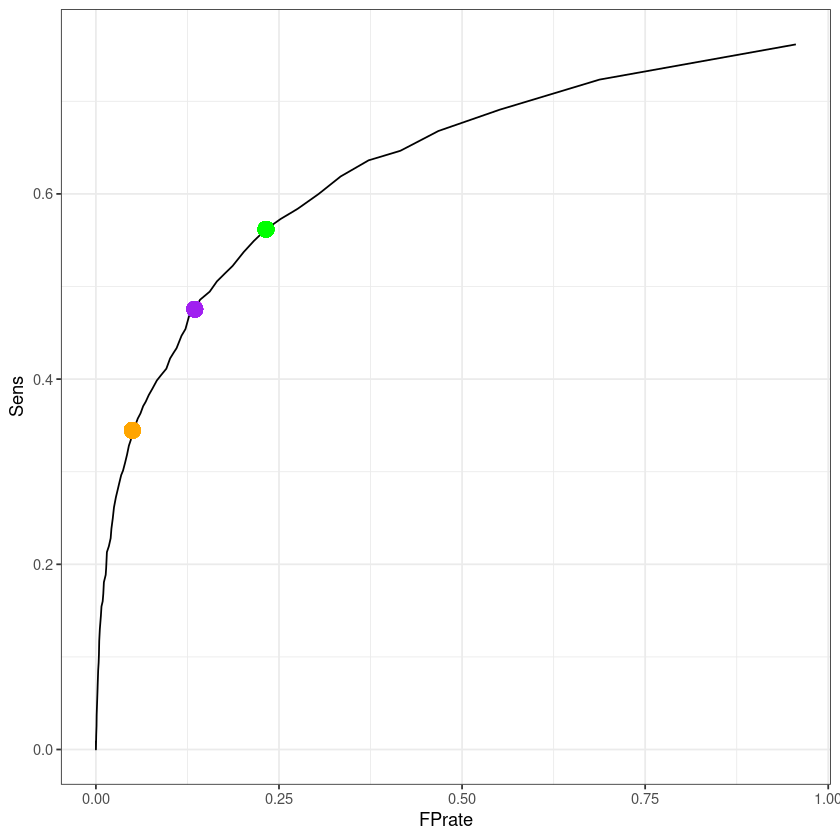

In [38]:
# This is the ROC curve - note that the y-axis does not reach 0.8... ugh!
ggplot(hurdlesdf,aes(x=FPrate,y=Sens)) + geom_line() + 
        geom_point(x=0.1350185, y=0.4754358, color="purple", size=4) + 
        geom_point(x=0.2322236, y=0.5618067, color="green", size=4) +
        geom_point(x=0.04973284, y=0.344691, color="orange", size=4) +
        theme_bw()

In the above graph, the green point is the performance under the maximum TP per FP. The purple point is the performance at the traditional hurdle of number of detections = known number of penguins. More on this below.

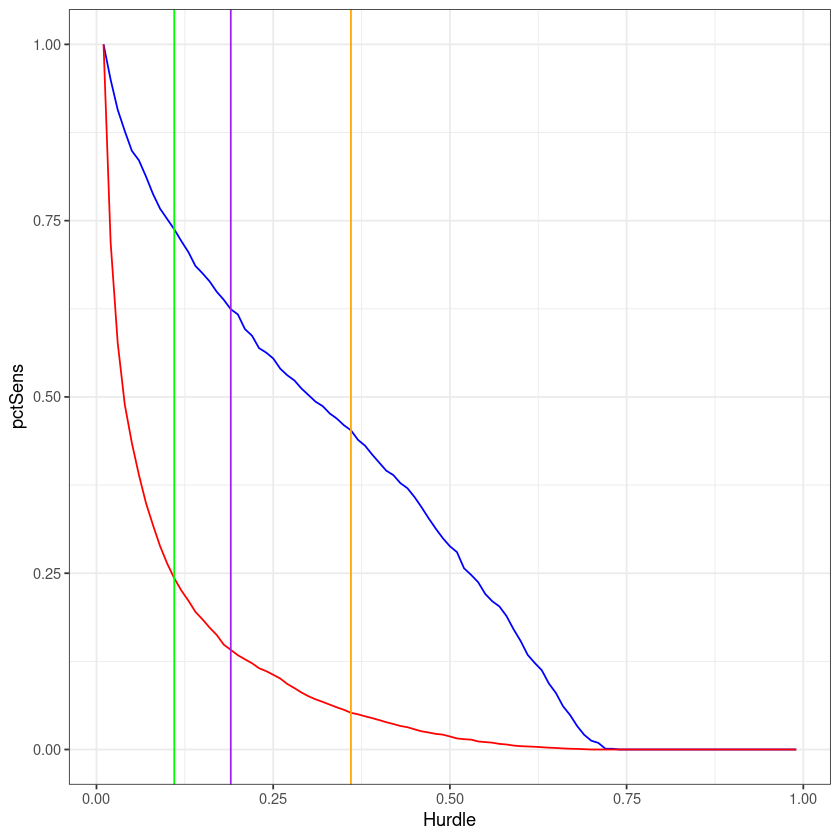

In [39]:
plotdf<-hurdlesdf[,c("Hurdle","truePos","falsePos","falseNeg","Sens","FPrate","FPper")]
plotdf$pctSens<-plotdf$Sens/max(plotdf$Sens) # percent of TP as % of max
plotdf$pctFPrt<-plotdf$FPrate/max(plotdf$FPrate) # percent of FP as % of max
ggplot(plotdf,aes(x=Hurdle)) + geom_line(aes(y=pctSens),color="blue") + 
            geom_line(aes(y=pctFPrt),color="red") + 
            geom_vline(xintercept=0.11, color="green") + 
            geom_vline(xintercept=0.19, color="purple") + 
            geom_vline(xintercept=0.36, color="orange") + theme_bw()

The segment (green and purple) within the blue and red lines is very similar for both hurdle approaches.

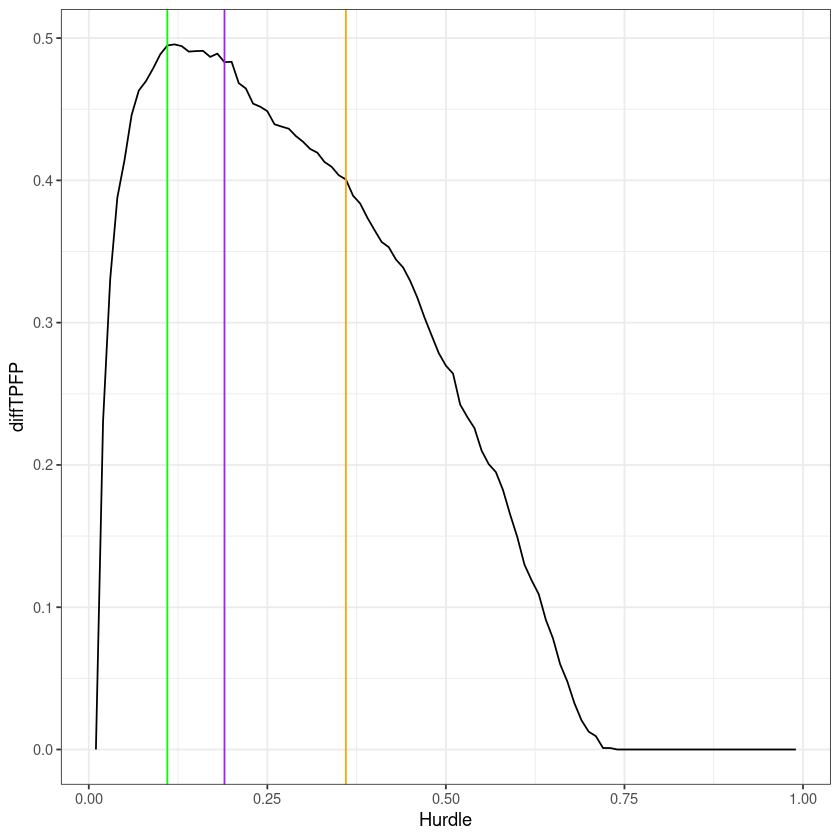

In [40]:
plotdf$diffTPFP<-plotdf$pctSens-plotdf$pctFPrt
ggplot(plotdf,aes(x=Hurdle,y=diffTPFP)) + geom_line() + 
        geom_vline(xintercept=0.11, color="green") + 
        geom_vline(xintercept=0.19, color="purple") + 
        geom_vline(xintercept=0.36, color="orange") + theme_bw()

The above graph shows the hurdle at which we maximize the number of TP per (unit of) FP - the green line. It also shows the hurdle for the traditional hurdle value (where number of detections = number of known penguins, the purple line). That's about 0.11 and 0.19 respectively (more on this below). A hurdle lower than 0.11 results in a lot more FP for about the same number of TPs. A hurdle above 0.11 results in fewer TP per FP (see below). But bottom-line, both hurdle values have comparable performance.

At the maxTP/FP hurdle point (green), the model detects at 75% the maximum sensitivity, and 25% of the maximum FPrate. This is the penalization point at which you get the most TP for the fewest FP, percent-wise. It does not mean that all detections approximate the total number of penguins (i.e., it is incorrect to assume that since you are getting 75% of the maximum sensitivity and 25% of the maximum FPrate, 75% +25% = 100%), because there are fewer FP detections than penguins, and far fewer TP than FP. There are 1,262 penguins (961 TP and 301 FN) and 4,651 FP. This is shown below.


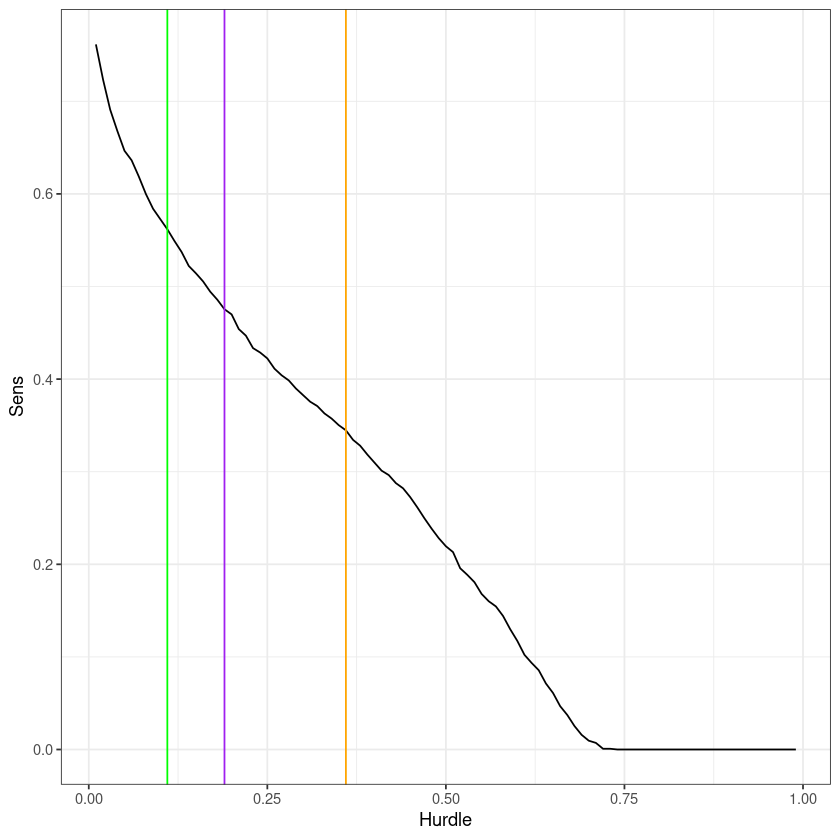

In [41]:
ggplot(hurdlesdf,aes(x=Hurdle,y=Sens)) + geom_line() + 
        geom_vline(xintercept=0.11, color="green") + 
        geom_vline(xintercept=0.19, color="purple") + 
        geom_vline(xintercept=0.36, color="orange") + theme_bw()

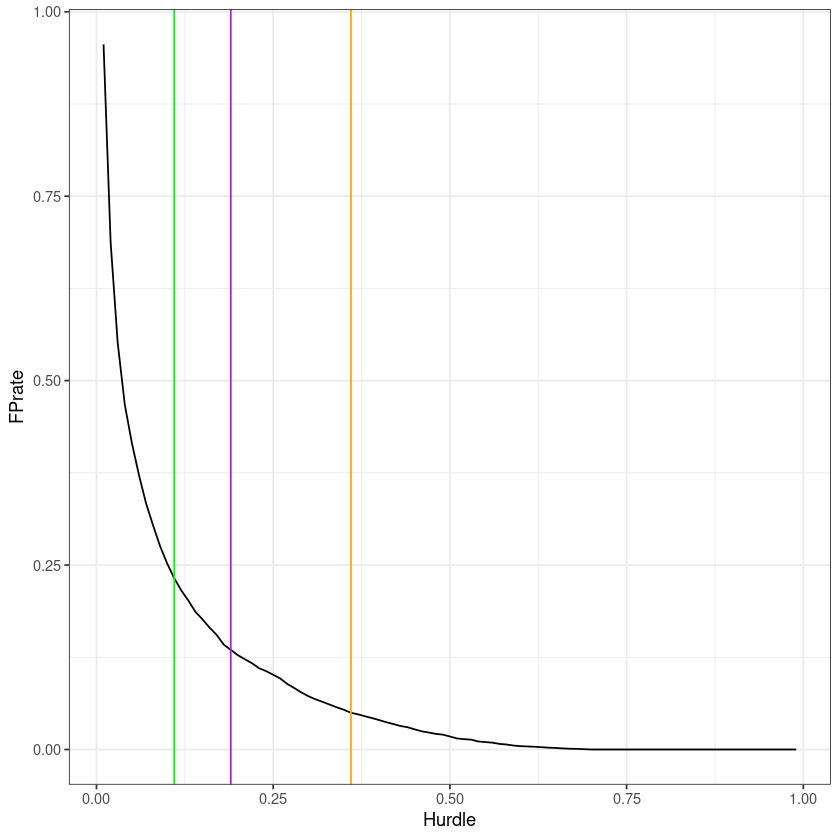

In [42]:
ggplot(hurdlesdf,aes(x=Hurdle,y=FPrate)) + geom_line() + 
        geom_vline(xintercept=0.11, color="green") + 
        geom_vline(xintercept=0.19, color="purple") + 
        geom_vline(xintercept=0.36, color="orange") + theme_bw()

So, in reality at this hurdle point we get about 56% of all penguins detected (709 penguins) from the TP, and about 22% of all FP (1130 "penguins"). We can plot the estimates at each hurdle point, indicating how many are TP and how many FP we get at each hurdle, like so:

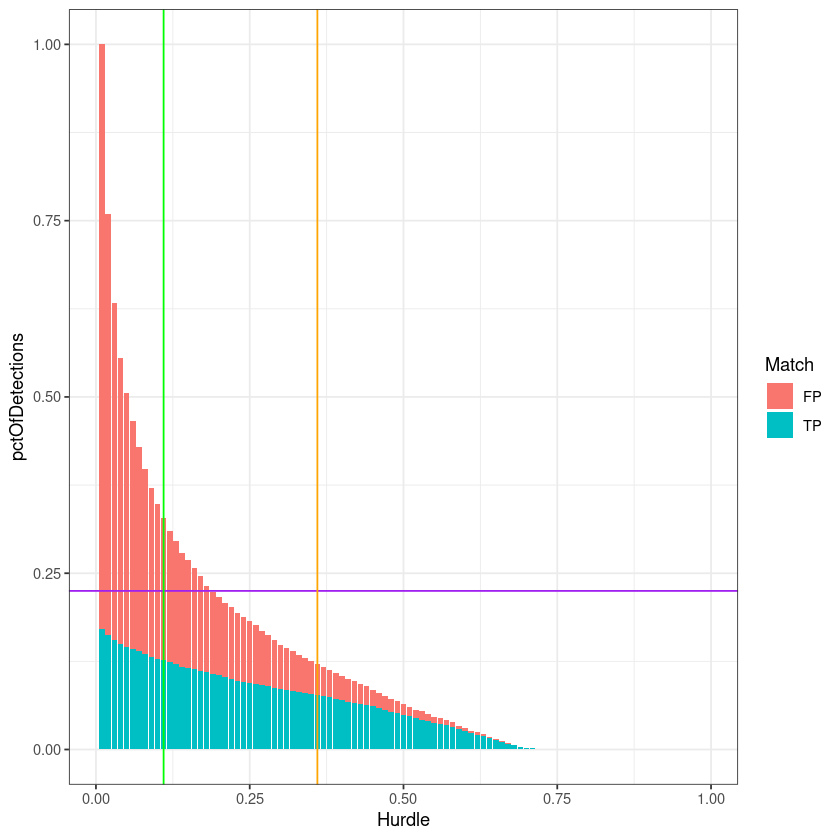

In [43]:
#need a table with two rows for the same hurdle, a col with count, and a col with TP/FP
#then do a stacked bar...
plotdf$pctTP<-plotdf$truePos/5612  #5612 is the total number of detections (i.e., TP + FP)
plotdf$pctFP<-plotdf$falsePos/5612
pplotdf<-reshape(plotdf[,c("Hurdle","pctTP","pctFP")],direction="long",idvar="Hurdle",varying=list(2:3),
                 times=c("TP","FP"),v.names="pctOfDetections",timevar="Match")
ggplot(pplotdf,aes(x=Hurdle,y=pctOfDetections)) + geom_bar(aes(fill=Match),position="stack",stat="identity") +
        geom_hline(yintercept=0.2249, color="purple") +
        geom_vline(xintercept=0.11, color="green") + 
        geom_vline(xintercept=0.36, color="orange") + theme_bw()

In the above graphic, the purple line is the percent of detections that would be the equivalent to the total number of penguins found in the validations (1,262 penguins). So, the hurdle at 0.11 overshoots (there is still a good portion of the red bar above the purple line). At this hurdle there are 1,839 detections, or 577 more than there are penguins in the sample. So, one way to estimate the number of penguins is:  
  * Hurdle total number of detections at 0.11 (this is the hurdle at which we maximize the number of TP per FP)
  * Multiply estimate by 0.686

The standard approach is to find the hurdle at which the total number of detections matches the total number of penguins found, even if this means a worse ratio of TP/FP. However, since the hurdle at which the number of detections match the known number of penguins is not far from the maximum number of correct detections per false positive, we could consider using this traditional hurdle point. 

In [17]:
plotdf$sumPCT<-plotdf$pctTP + plotdf$pctFP
subset(plotdf,sumPCT<=0.2248753)[1,]
subset(plotdf,Hurdle==0.11)

,Hurdle,truePos,falsePos,falseNeg,Sens,FPrate,FPper,pctSens,pctFPrt,diffTPFP,pctTP,pctFP,sumPCT
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,0.19,600,657,662,0.4754358,0.1350185,0.522673,0.6243496,0.1412599,0.4830897,0.1069138,0.1170706,0.2239843


,Hurdle,truePos,falsePos,falseNeg,Sens,FPrate,FPper,pctSens,pctFPrt,diffTPFP,pctTP,pctFP,sumPCT
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11,0.11,709,1130,553,0.5618067,0.2322236,0.6144644,0.7377732,0.2429585,0.4948146,0.1263364,0.2013542,0.3276907


The traditional hurdle point is 0.19 and at this hurdle the percent of TP is 10.7% of all detections, whereas at the maximum TP per FP the percent of TP is 12.5% of all detections. About every 1 in 2 detections with either hurdle is a FP.

Finally, we could use a hurdle point where FP are <10% of all detections. This point would be...

In [21]:
subset(plotdf,FPper<=0.1)[1,]

,Hurdle,truePos,falsePos,falseNeg,Sens,FPrate,FPper,pctSens,pctFPrt,diffTPFP,pctTP,pctFP,sumPCT
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
67,0.67,47,5,1215,0.03724247,0.001027538,0.09615385,0.04890739,0.001075038,0.04783235,0.008374911,0.000890948,0.009265859


This means hurdling at 0.67 and leaves us with only 52 detections (47 + 5), which means an inflation rate of 24,269! Forget about that! Another alternative is to look for a different trade-off between TP and FP. The index F0.5 is one such compromise (this is the Fvalue but at beta = 0.5)

Warning message:
“Removed 26 row(s) containing missing values (geom_path).”


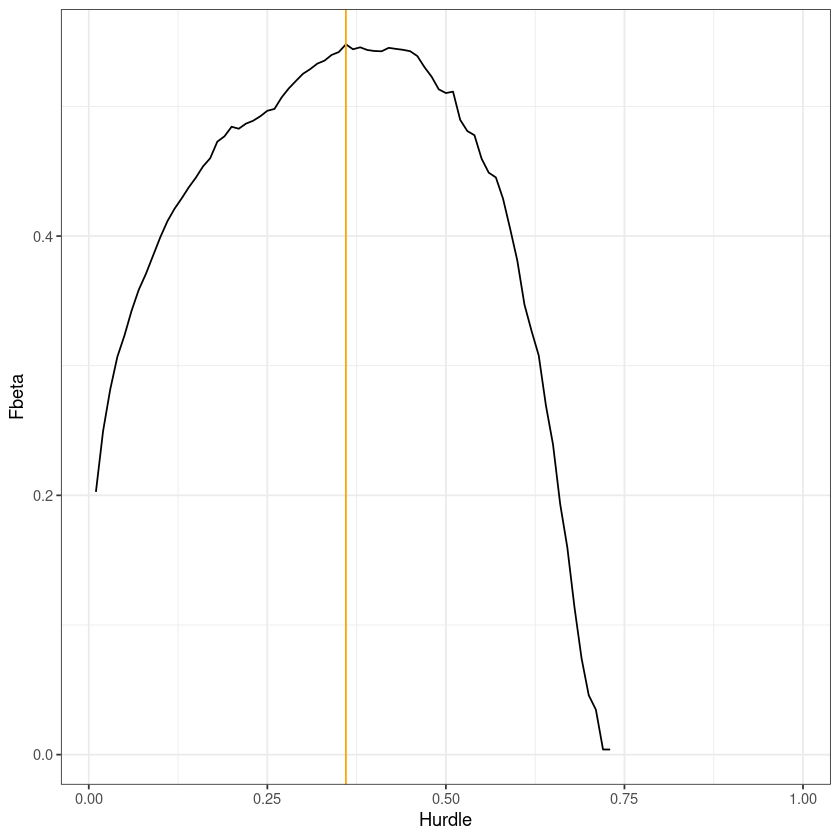

In [32]:
ggplot(hurdlesdf,aes(x=Hurdle,y=Fbeta)) + geom_line() + 
        geom_vline(xintercept=0.36, color="orange") + theme_bw()

In [37]:
subset(plotdf,Hurdle>0.351 & Hurdle<0.37)

,Hurdle,truePos,falsePos,falseNeg,Sens,FPrate,FPper,pctSens,pctFPrt,diffTPFP,pctTP,pctFP,sumPCT
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36,0.36,435,242,827,0.344691,0.04973284,0.3574594,0.4526535,0.05203182,0.4006217,0.07751247,0.04312188,0.1206344


At this hurdle, the total number of detections is 677 (about half of all known penguins), so we would inflate by 1.864. The percent of FP per TP is 0.36 - so, 1 of every 3 detections is a FP. (This skew of fewer FP per TP is the whole point of using maxF0.5)